## Demo 2: Raster data analysis - A simple suitability model to identify the best habitat to set aside for bobcat

- Basics of running Map algebra
- Working with Geoprocessing tools
- Working with operators
- Create complex expressions
- Using classes for complex parameters
- Using vector analysis and non SA/IA tools
- Chaining tools using managed output (#)
- Analysis environment

### What is a suitability model?

A suitability model identifies the best locations to site things such as a new shopping center, a housing development, or a ski area or it identifies the best areas to set aside for things such as parks, bobcat habitat, or for flood control.  


### Bobcat habitat example
In our simple bobcat example, our goal is to identify the best areas to set aside for bobcat habitat and we will have three criteria:

1. Slope – for safety, they prefer steeper over flatter slopes

2. Land use types – they prefer certain land use types (such as deciduous and conifer forests) more than others (such as commercial and residential)

3. Distance to streams – locations closer to streams are more preferred

![suitability_workflow](suitability_workflow.png)

In [30]:
import arcpy
from arcpy.sa import *
from arcpy.ia import *

### Prepare the criterion of slope

In [31]:
elev = Raster('C:\DevSummit20\PythonRaster\Data\SuitabilityModeling\Input\elevation_f')

In [32]:
elev_m = elev * 0.3048
slope = Slope(elev_m)

In [33]:
# slope = Slope(elev * 0.3048)  # alternative way to chain operations together

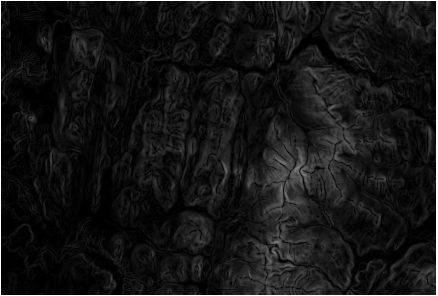

In [34]:
slope

#### Remap slope degree to suitability scores:

| Start | End | Suitability Score |
|-------|-----|-----|
| 0     | 3   | 1   |
| 3     | 10  | 3   |
| 10    | 25  | 6   |
| 25    | 90  | 10  |

In [35]:
remap_table = RemapRange([[0,3,1], [3,10,3], [10,25,6], [25,90,10]])

In [36]:
slope_transformed = Reclassify(slope, "Value", remap_table)

### Prepare the criterion of land use

In [37]:
landuse = Raster('C:\DevSummit20\PythonRaster\Data\SuitabilityModeling\Input\landuse_f')

#### Remap landuse to suitability scores:

| Landuse                            | Old Value | New Value |
|------------------------------------|-----------|-----------|
| Agriculture                        | 4         | 2         |
| Bare Land                          | 11        | 10        |
| Developed, High Intensity          | 1         | 1         |
| Developed, Low Intensity           | 3         | 1         |
| Developed, Medium Intensity        | 2         | 1         |
| Forest, Coniferous                 | 7         | 10        |
| Forest, Deciduous                  | 6         | 10        |
| Forest, Mixed Deciduous-Coniferous | 8         | 10        |
| Grassland                          | 5         | 8         |
| Scrub/Shrub                        | 9         | 6         |
| Water                              | 12        | 1         |
| Wetland                            | 10        | 2         |

In [38]:
remap_table = RemapValue([[4,2], [11,10], [1,1], [3,1], [2,1], [7,10], 
                          [6,10] ,[8,10], [5,8], [9,6], [12,1], [10,2]])

In [39]:
landuse_transformed = Reclassify(landuse, "Value", remap_table)

### Prepare the criterion of distance to streams

In [40]:
arcpy.Clip_analysis("Streams", "StudyArea", "C:\DevSummit20\PythonRaster\Data\SuitabilityModeling\Output\streams_clip.shp")

<Result 'C:\\DevSummit20\\PythonRaster\\Data\\SuitabilityModeling\\Output\\streams_clip.shp'>

In [41]:
dist_to_streams = DistanceAccumulation("C:\DevSummit20\PythonRaster\Data\SuitabilityModeling\Output\streams_clip.shp")

#### Alternative way that combines non-raster tool with raster tool in one single expression

In [82]:
# dist_to_streams = DistanceAccumulation(arcpy.Clip_analysis("Streams", "StudyArea", "#")) 

In [42]:
dist_to_streams_transformed = RescaleByFunction(dist_to_streams, TfMSSmall(), 1, 10)

### Weight criteria relative to one another and combine

In [43]:
suitability_map = slope_transformed * 0.2 + \
                  landuse_transformed * 0.5 + \
                  dist_to_streams_transformed * 0.3

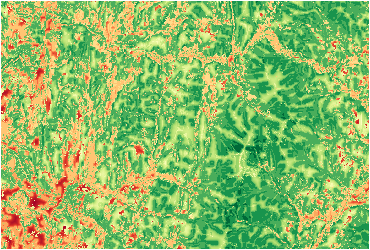

In [44]:
Render(suitability_map, colormap="Red-Yellow-Green (Continuous)")

### Analysis environment

In [45]:
arcpy.env.cellSize = 100

In [46]:
arcpy.env.outputCoordinateSystem = arcpy.SpatialReference(3857)  # Web_Mercator_Auxiliary_Sphere

### Everything in one complex expression

In [47]:
suitability_map = Reclassify(Slope(elev * 0.3048), 
                             "Value", 
                             RemapRange([[0,3,1], [3,10,3], [10,25,6], [25,90,10]])) * 0.2 + \
                  Reclassify(landuse, 
                             "Value", 
                             RemapValue([[4,2], [11,10], [1,1], [3,1], [2,1], [7,10], 
                                         [6,10] ,[8,10], [5,8], [9,6], [12,1], [10,2]])) * 0.5 + \
                  RescaleByFunction(DistanceAccumulation(arcpy.Clip_analysis("Streams", 
                                                                             "StudyArea", 
                                                                             "#")), 
                                    TfMSSmall(), 1, 10) * 0.3

In [48]:
print('Output cell size is {} x {}'.format(suitability_map.meanCellHeight, 
                                           suitability_map.meanCellWidth))

Output cell size is 100.0 x 100.0


In [49]:
print("Output map project is {}".format(suitability_map.spatialReference.PCSName))

Output map project is WGS_1984_Web_Mercator_Auxiliary_Sphere
